- 请复现Cameron and Trivedi (2005) 的 11.36(13.6?) 的内容
- 请研究 Prior 在样本增加时对于 Posterior 的影响大小

# 1. Replication of 13.6

In [1]:
import jax 
from jax import lax
from jax import random
import jax.numpy as jnp
from jax.lax import dot_general as dot

In [2]:
from jax.scipy import linalg
from scipy import stats

In [3]:
def gen(N, seed=0):
    # keys for dgp
    key = random.PRNGKey(seed)
    key1, key2, key3 = random.split(key, 3)
    X1 = random.normal(key1, shape=(N, 1))
    dummy1 = jnp.ones((N, 1))
    X1 = jnp.hstack((dummy1, X1))
    X2 = random.normal(key2, shape=(N, 1))
    dummy2 = jnp.ones((N, 1))
    X2 = jnp.hstack((dummy2, X2))

    X = linalg.block_diag(X1, X2)
    # X1
    #   X2

    true_Beta = jnp.array([1., 1., 1., 1.,])

    y = dot(X, true_Beta, (((1,),(0,)), ((),())))
    # y1 1000,
    # y2 1000,

    true_sigma = jnp.array([[1., -0.5],
                   [-0.5, 1.]])
    
    eps_ = random.multivariate_normal(key3, mean=jnp.zeros(2), cov=true_sigma, shape=(N,))
    # e1, e2
    true_eps = jnp.hstack((eps_[:, 0], eps_[:, 1]))
    y = y + true_eps

    Y = jnp.hstack((y[:N][:,None], y[N:][:,None]))
    X_star = jnp.hstack((X1, X2))

    return X, y, X_star, Y
    

In [4]:
# update beta
def cal_C0(B0, X, sigma, T=1000):
    I_t = jnp.eye(T)
    s = jnp.kron(jnp.linalg.inv(sigma), I_t) # TM x TM
    tmp = dot(s, X, (((1,),(0,)), ((),())))
    out = dot(X.T, tmp, (((1,), (0,)), ((), ())))
    # out = X.T @ (s @ X) # kK x TM dot (TM x TM  dot  TM x K)
    out = jnp.linalg.inv(B0 + out)
    return out


def cal_multiplier(B0, beta_0, sigma, X, y, T=1000):
    I_t = jnp.eye(T)
    s = jnp.kron(jnp.linalg.inv(sigma), I_t) # TM x TM
    tmp = dot(s, y, (((1,), (0,)), ((), ())))
    out = dot(X.T, tmp, (((1,), (0,)), ((), ())))
    # out = X.T @ (s @ y) # K x TM dot (TM x TM dot TM x 1)
    tmp = dot(B0, beta_0, (((1,), (0,)), ((), ())))
    out = tmp.squeeze() + out
    # out = (B0 @ beta_0).squeeze() + out
    return out


def update_beta(B0, beta_0, sigma, X, y, N):
    new_normal_cov = cal_C0(B0, X, sigma, N)
    tmp = cal_multiplier(B0, beta_0, sigma, X, y, N)
    # new_normal_mu = new_normal_cov @ tmp 
    new_normal_mu = dot(new_normal_cov, tmp, (((1,), (0,)), ((), ())))
    key = random.PRNGKey(0)
    new_beta = random.multivariate_normal(key, new_normal_mu, new_normal_cov)
    return new_beta

In [5]:
# update sigma
def cal_A(X_star, Y, Beta):
    B = linalg.block_diag(Beta[:2][:,None], Beta[2:][:, None]) # K x M 
    tmp = dot(X_star, B, (((1,), (0,)), ((), ()))) 
    # A = (Y - X_star @ B).T @ (Y - X_star @ B)
    A = dot((Y - tmp).T, Y - tmp, (((1,), (0,)), ((), ())))
    return A


def cal_scale(D0, X_star, Y, Beta):
    A = cal_A(X_star, Y, Beta)
    return (jnp.linalg.inv(D0) + A)


def update_sigma(v0, N, D0, X_star, Y, Beta):
    new_v = v0 + N
    new_scale = cal_scale(D0, X_star, Y, Beta)
    new_sigma = jnp.array(stats.invwishart.rvs(new_v, new_scale))
    return new_sigma

In [6]:
from jax.ops import index, index_update

In [7]:
def gibbs(steps, beta_init, sigma_init, burnin=5000):
    betas = jnp.zeros((steps, 4))
    sigmas = jnp.zeros((steps, 2, 2))
    Beta = beta_init
    Sigma = sigma_init

    for k in range(steps + burnin):
        Beta = update_beta(B0, beta_0, Sigma, X, y, N)
        Sigma = update_sigma(v0, N, D0, X_star, Y, Beta)
        if k >= burnin:
            i = k - burnin
            betas = index_update(betas, index[i, 0], Beta[0])
            betas = index_update(betas, index[i, 1], Beta[1])
            betas = index_update(betas, index[i, 2], Beta[2])
            betas = index_update(betas, index[i, 3], Beta[3])
            sigmas = index_update(sigmas, index[i, 0, 0], Sigma[0][0])
            sigmas = index_update(sigmas, index[i, 0, 1], Sigma[0][1])
            sigmas = index_update(sigmas, index[i, 1, 0], Sigma[1][0])
            sigmas = index_update(sigmas, index[i, 1, 1], Sigma[1][1])
    
    return betas, sigmas

## Experiment 1
$\tau$=10, N=1000, steps=50000

In [ ]:
# exp1 tau=10, N=1000, steps=50000
N = 1000
X, y, X_star, Y = gen(N, 233)

# priors
beta_0 = jnp.zeros((4,1)) # prior mean--- KM x 1
tau = 10 
B0 = tau * jnp.eye(4) # precision matrix--- KM x KM (total num of params)
D0 = jnp.eye(2) # wishart second--- M x M
v0 = 5 # wishart first

# init params
key = random.PRNGKey(2)
key1, key2 = random.split(key, 2)
Beta_init = random.multivariate_normal(key1, beta_0.squeeze(), jnp.linalg.inv(B0))
tmp = stats.invwishart.rvs(v0, D0)
Sigma_init = jnp.array(tmp)

In [ ]:
bchain, schain = gibbs(50000, Beta_init, Sigma_init)

In [ ]:
print(f'beta mean: {jnp.mean(bchain, axis=0)}\nbeta std: {jnp.std(bchain, axis=0)}\n\nsigma mean: \n{jnp.mean(schain, axis=0)}\nsigma std: \n{jnp.std(schain, axis=0)}')

beta mean: [1.071108   0.98882085 0.9476167  0.9255525 ]
beta std: [0.00099545 0.00086501 0.00165615 0.00085579]

sigma mean: 
[[ 0.91684246 -0.4895489 ]
 [-0.4895489   0.9887918 ]]
sigma std: 
[[0.04076786 0.03367864]
 [0.03367864 0.04412883]]


## Experiment 2
$\tau$=1, N=1000, steps=50000

In [ ]:
# exp2 tau=1, N=1000, steps=50000
N = 1000
X, y, X_star, Y = gen(N, 555)

# priors
beta_0 = jnp.zeros((4,1)) # prior mean--- KM x 1
tau = 1 
B0 = tau * jnp.eye(4) # precision matrix--- KM x KM (total num of params)
D0 = jnp.eye(2) # wishart second--- M x M
v0 = 5 # wishart first

# init params
key = random.PRNGKey(666)
Beta_init = random.multivariate_normal(key, beta_0.squeeze(), jnp.linalg.inv(B0))
tmp = stats.invwishart.rvs(v0, D0)
Sigma_init = jnp.array(tmp)

In [ ]:
bchain2, schain2 = gibbs(50000, Beta_init, Sigma_init)
print(f'beta mean: {jnp.mean(bchain2, axis=0)}\nbeta std: {jnp.std(bchain2, axis=0)}\n\nsigma mean: \n{jnp.mean(schain2, axis=0)}\nsigma std: \n{jnp.std(schain2, axis=0)}')
      

beta mean: [1.0333867  0.9528782  1.0033783  0.91054475]
beta std: [0.00123949 0.0004312  0.0017625  0.00035347]

sigma mean: 
[[ 0.9773715  -0.51292413]
 [-0.51292413  1.0316911 ]]
sigma std: 
[[0.04367696 0.03569066]
 [0.03569066 0.04592285]]


## Experiment 3
$\tau$=0.1, N=1000, steps=50000

In [ ]:
# exp3 tau=0.1, N=1000, steps=50000
N = 1000
X, y, X_star, Y = gen(N, 1234)

# priors
beta_0 = jnp.zeros((4,1)) # prior mean--- KM x 1
tau = 0.1 
B0 = tau * jnp.eye(4) # precision matrix--- KM x KM (total num of params)
D0 = jnp.eye(2) # wishart second--- M x M
v0 = 5 # wishart first

# init params
key = random.PRNGKey(42)
key1, key2 = random.split(key, 2)
Beta_init = random.multivariate_normal(key1, beta_0.squeeze(), jnp.linalg.inv(B0))
tmp = stats.invwishart.rvs(v0, D0)
Sigma_init = jnp.array(tmp)

In [ ]:
bchain3, schain3 = gibbs(50000, Beta_init, Sigma_init)
print(f'beta mean: {jnp.mean(bchain3, axis=0)}\nbeta std: {jnp.std(bchain3, axis=0)}\n\nsigma mean: \n{jnp.mean(schain3, axis=0)}\nsigma std: \n{jnp.std(schain3, axis=0)}')

beta mean: [1.1249856  0.93063766 0.94829667 0.98241186]
beta std: [0.00126364 0.00056063 0.00167634 0.00046015]

sigma mean: 
[[ 0.97469604 -0.47954327]
 [-0.47954327  0.98644584]]
sigma std: 
[[0.04372931 0.0343993 ]
 [0.0343993  0.04410033]]


## Experiment 4
$\tau$=10, N=1000, steps=100000

In [ ]:
# exp4 tau=10, N=1000, steps=100000
N = 1000
X, y, X_star, Y = gen(N, 999)

# priors
beta_0 = jnp.zeros((4,1)) # prior mean--- KM x 1
tau = 10 
B0 = tau * jnp.eye(4) # precision matrix--- KM x KM (total num of params)
D0 = jnp.eye(2) # wishart second--- M x M
v0 = 5 # wishart first

# init params
key = random.PRNGKey(14)
key1, key2 = random.split(key, 2)
Beta_init = random.multivariate_normal(key1, beta_0.squeeze(), jnp.linalg.inv(B0))
tmp = stats.invwishart.rvs(v0, D0)
Sigma_init = jnp.array(tmp)

In [ ]:
bchain4, schain4 = gibbs(100000, Beta_init, Sigma_init)
print(f'beta mean: {jnp.mean(bchain4, axis=0)}\nbeta std: {jnp.std(bchain4, axis=0)}\n\nsigma mean: \n{jnp.mean(schain4, axis=0)}\nsigma std: \n{jnp.std(schain4, axis=0)}')

beta mean: [1.0551479 0.9772198 0.9526461 1.0094603]
beta std: [0.00112902 0.00086685 0.00156448 0.00154567]

sigma mean: 
[[ 1.0735419  -0.56289333]
 [-0.5628933   1.0357339 ]]
sigma std: 
[[0.04815196 0.03773081]
 [0.03773081 0.04636731]]


## Experiment 5
$\tau$=10, N=10000, steps=100000

In [ ]:
# exp5 tau=10, N=10000, steps=100000
N = 10000
X, y, X_star, Y = gen(N, 876)

# priors
beta_0 = jnp.zeros((4,1)) # prior mean--- KM x 1
tau = 10 
B0 = tau * jnp.eye(4) # precision matrix--- KM x KM (total num of params)
D0 = jnp.eye(2) # wishart second--- M x M
v0 = 5 # wishart first

# init params
key = random.PRNGKey(543)
key1, key2 = random.split(key, 2)
Beta_init = random.multivariate_normal(key1, beta_0.squeeze(), jnp.linalg.inv(B0))
tmp = stats.invwishart.rvs(v0, D0)
Sigma_init = jnp.array(tmp)

In [ ]:
bchain5, schain5 = gibbs(100000, Beta_init, Sigma_init)
print(f'beta mean: {jnp.mean(bchain5, axis=0)}\nbeta std: {jnp.std(bchain5, axis=0)}\n\nsigma mean: \n{jnp.mean(schain5, axis=0)}\nsigma std: \n{jnp.std(schain5, axis=0)}')

beta mean: [0.9991115  0.99342287 1.0139067  0.9967205 ]
beta std: [1.2024414e-04 1.7212481e-04 1.6849977e-04 6.2748702e-05]

sigma mean: 
[[ 0.96747684 -0.4862456 ]
 [-0.48624554  0.98715985]]
sigma std: 
[[0.01375325 0.0109615 ]
 [0.0109615  0.01401998]]


13.6 
Table 13.3
![](https://i.imgur.com/zZ5wAfZ.png)

My Results

| Prior $\tau$<br>Sample size N<br>Gibbs repls 	| 10<br>1,000<br>50,000 	| 1<br>1,000<br>50,000 	| 1/10<br>1,000<br>50,000 	| 10,<br>1,000<br>100,000 	| 10<br>10,000<br>100,000 	|
|----------------------------------------------	|-----------------------	|----------------------	|-------------------------	|-------------------------	|-------------------------	|
| $\beta_{11}$  | 1.071<br>(0.0010)     	|1.033<br>(0.0012) |  1.125<br>(0.0013)|  1.055<br>(0.0011)  	|     0.999<br>(0.00012)                    	|
| $\beta_{12}$     	| 0.989<br>(0.0009)|0.953<br>(0.0004) | 0.931<br>(0.0006)	|    0.977<br>(0.0009)               	|         0.993<br>(0.00017)  	|
| $\beta_{21}$     	| 0.948<br>(0.0017)	| 1.003<br>(0.0018)	| 0.948<br>(0.0017)	|   0.953<br>(0.0016)             	|           1.014<br>(0.00017)               	|
| $\beta_{22}$  	|0.926<br>(0.0009) | 0.911<br>(0.0004)|0.982<br>(0.0005) 	|        1.009<br>(0.0015) |     0.997<br>(0.00006)  |
| $\sigma_{11}$   	|0.917<br>(0.0408) | 0.977<br>(0.0437)| 0.975<br>(0.044)	| 1.074<br>(0.0482)   |      0.967<br>(0.0138)  |
| $\sigma_{12}$  	| -0.490<br>(0.0337)| -0.513<br>(0.0357)| -0.480<br>(0.0344)	|   -0.563<br>(0.0377)   	|   -0.486<br>(0.0110)                      	|
| $\sigma_{22}$ 	|0.989<br>(0.044) |1.031<br>(0.0459)| 0.986<br>(0.0441)| 1.036<br>(0.0464)                         	|    0.987<br>(0.0140)                     	|

# 2. Sample size & the influence of prior on posterior
- We know that the posterior distribution is proportional to the product of the prior and the likelihood, or, the sum on the log scale. Since the likelihood scales with the sample size, but the prior does not, a reasonable guess is that the posterior becomes more heavily influenced by the likelihood as the sample size increases.
- Now let us conduct an experiment.

## Experiment 6
$\tau=0.01$, $\beta_0 = 20$, $D_0=100$, $v_0=1000$

N=100, steps=20000

In [8]:
# exp 6
# use ''bad'' priors for different sample size to check whether the posterior would be drifted

# "bad" priors
beta_0 = jnp.zeros((4,1)) + 20. # prior mean--- KM x 1
tau = 0.01
B0 = tau * jnp.eye(4) # precision matrix--- KM x KM (total num of params)
D0 = jnp.eye(2) * 100 # wishart second--- M x M
v0 = 1000 # wishart first

# init params 
key = random.PRNGKey(7)
key1, key2 = random.split(key, 2)
Beta_init = random.multivariate_normal(key1, beta_0.squeeze(), jnp.linalg.inv(B0))
tmp = stats.invwishart.rvs(v0, D0)
Sigma_init = jnp.array(tmp)

print(Beta_init)
print(Sigma_init)

[32.940605 22.11784  19.58516  31.682552]
[[0.09738881 0.00663169]
 [0.00663169 0.09309409]]


In [19]:
# Small sample size
N = 100 
X, y, X_star, Y = gen(N, 777)
print(X.shape, y.shape, X_star.shape, Y.shape)

(200, 4) (200,) (100, 4) (100, 2)


In [20]:
bch, sch = gibbs(20000, Beta_init, Sigma_init, 5000)
print(f'beta mean: {jnp.mean(bch, axis=0)}\nbeta std: {jnp.std(bch, axis=0)}\n\nsigma mean: \n{jnp.mean(sch, axis=0)}\nsigma std: \n{jnp.std(sch, axis=0)}')

beta mean: [1.0521065 1.1746675 0.8870448 1.1035442]
beta std: [0.00110992 0.00280109 0.00141083 0.00168117]

sigma mean: 
[[ 0.09369922 -0.0417194 ]
 [-0.0417194   0.08663741]]
sigma std: 
[[0.00397859 0.00298619]
 [0.00298619 0.00371236]]


## Experiment 7
$\tau=0.01$, $\beta_0 = 20$, $D_0=100$, $v_0=1000$

N=10000, steps=20000

In [9]:
# Larger sample size
N = 10000
X, y, X_star, Y = gen(N, 777)
print(X.shape, y.shape, X_star.shape, Y.shape)

(20000, 4) (20000,) (10000, 4) (10000, 2)


In [10]:
bch2, sch2 = gibbs(20000, Beta_init, Sigma_init, 5000)
print(f'beta mean: {jnp.mean(bch2, axis=0)}\nbeta std: {jnp.std(bch2, axis=0)}\n\nsigma mean: \n{jnp.mean(sch2, axis=0)}\nsigma std: \n{jnp.std(sch2, axis=0)}')

beta mean: [1.0145483  0.99004215 0.9838576  0.98913646]
beta std: [1.1545528e-04 4.1313357e-05 1.5581232e-04 3.4818971e-05]

sigma mean: 
[[ 0.89503586 -0.44346067]
 [-0.44346067  0.89904416]]
sigma std: 
[[0.01202122 0.00956041]
 [0.00956041 0.01211932]]


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")
sns.set_palette("pastel")

import warnings
warnings.filterwarnings('ignore')

Text(0.5, 1.0, 'N=100')

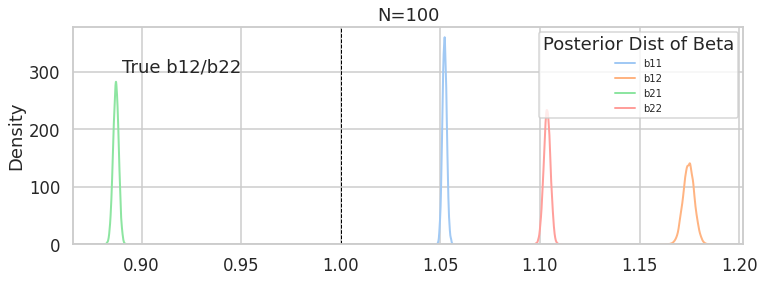

In [22]:
plt.figure(figsize=(12,4))
blabels = ['b11', 'b12', 'b21', 'b22']
for i in range(4):
    sns.distplot(bch[:, i], hist=False, kde=True, kde_kws = {'linewidth': 2},label=blabels[i])

plt.axvline(1.0, 0,300, color='k', linestyle='dashed', linewidth=1)
# plt.axvline(2.0, 0,300, color='k', linestyle='dashed', linewidth=1)
# plt.text(1.88, 300, "True b11/b21")
plt.text(0.89, 300, "True b12/b22")
plt.legend(prop={'size': 10}, title = 'Posterior Dist of Beta')
plt.title('N=100')

Text(0.5, 1.0, 'N=100')

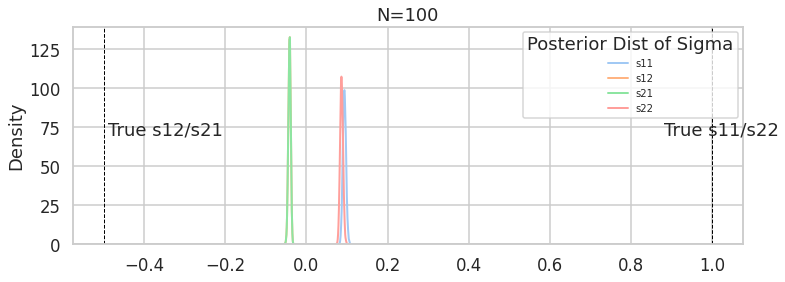

In [23]:
plt.figure(figsize=(12,4))
slabels = ['s11', 's12', 's21', 's22']
for k, (i,j) in enumerate([(0,0), (0, 1), (1,0), (1,1)]):
    sns.distplot(sch[:, i, j], hist=False, kde=True, kde_kws = {'linewidth': 2},label=slabels[k])
plt.axvline(-0.5, 0,80, color='k', linestyle='dashed', linewidth=1)
plt.axvline(1., 0, 80 , color='k', linestyle='dashed', linewidth=1)
plt.text(0.88, 70, "True s11/s22")
plt.text(-0.49, 70, "True s12/s21")
plt.legend(prop={'size': 10}, title = 'Posterior Dist of Sigma')
plt.title('N=100')

Text(0.5, 1.0, 'N=10000')

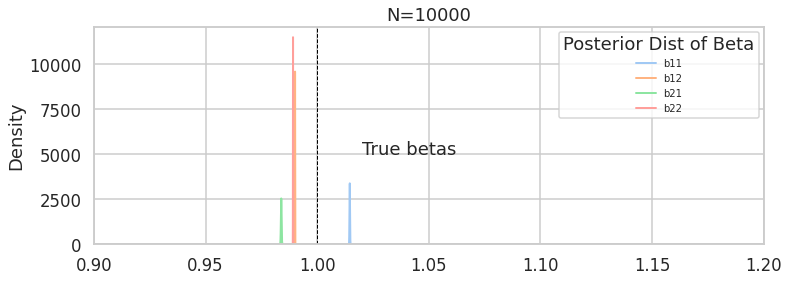

In [25]:
plt.figure(figsize=(12,4))
blabels = ['b11', 'b12', 'b21', 'b22']
for i in range(4):
    sns.distplot(bch2[:, i], hist=False, kde=True, kde_kws = {'linewidth': 2},label=blabels[i])

plt.axvline(1.0, 0,8000, color='k', linestyle='dashed', linewidth=1)
# plt.axvline(2.0, 0,8000, color='k', linestyle='dashed', linewidth=1)
# plt.text(1.87, 5000, "True betas")
plt.text(1.02, 5000, "True betas")
plt.xlim([0.9, 1.2])
plt.legend(prop={'size': 10}, title = 'Posterior Dist of Beta')
plt.title('N=10000')

Text(0.5, 1.0, 'N=10000')

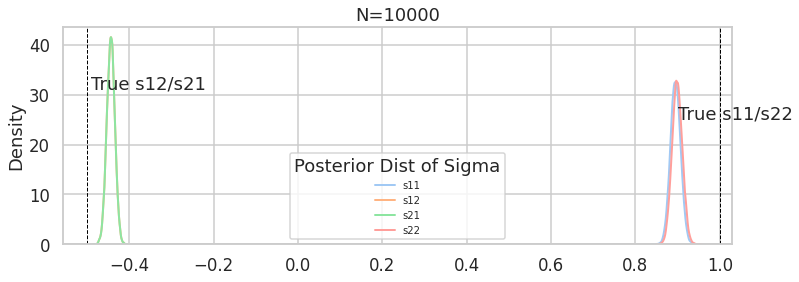

In [18]:
plt.figure(figsize=(12,4))
slabels = ['s11', 's12', 's21', 's22']
for k, (i,j) in enumerate([(0,0), (0, 1), (1,0), (1,1)]):
    sns.distplot(sch2[:, i, j], hist=False, kde=True, kde_kws = {'linewidth': 2},label=slabels[k])
plt.axvline(-0.5, 0, 35, color='k', linestyle='dashed', linewidth=1)
plt.axvline(1., 0, 35, color='k', linestyle='dashed', linewidth=1)
plt.text(0.9, 25, "True s11/s22")
plt.text(-0.49, 31, "True s12/s21")
plt.legend(prop={'size': 10}, title = 'Posterior Dist of Sigma')
plt.title('N=10000')

## Conclusion
The experiment verifies our guess: the prior has greater impact on the posterior with small sample size, but with large sample size, the posterior converges to the true values. 

# 3. Implementation Notes
- The formula listed on page 453 seems **mistaken**. We can easily check the dimensions of the matrices, say, $C_0$, to verify: let `m` be the numebr of equations (2 here), `q` be the number of parameters in each equation (also 2 here since we added intercept), then $C_0$ should be `mq x mq`, also is $B_0$; however, $x_i$ is `m x q` and $\Sigma$ is `m x m`, and then $\sum_i^{N} x_i' \Sigma^{-1} x_i$ is `m x m` which does not match the dimension of $B_0$ or $C_0$.

![](https://i.imgur.com/bLMSxWp.png)

- Therefore, I use the following formula from [Griffiths(2001)](https://core.ac.uk/download/pdf/6561736.pdf) to update beta and sigma, but with some modification----adding priors----in order to follow the idea of Cameron and Trivedi(2005). The experiments seem to confirm my thoughts. 

![](https://i.imgur.com/0qv5abF.png)

![](https://i.imgur.com/qbxaipU.png)

![](https://i.imgur.com/WSp78Ss.png)

In [ ]:
|